In [1]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import json
import copy
from scipy.optimize import curve_fit
import math
from scipy import fft
from numpy import loadtxt
import sys

In [2]:
def initLattice(latticeSize: int, hot: bool) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    if hot:
        for i in range(latticeSize):
            for j in range(latticeSize):
                #pick a random spin
                spin = 0
                randomInt = random.randint(0,1)
                if(randomInt == 1):
                    spin = 1
                else:
                    spin = -1
                #set lattice site equal to the random spin    
                lattice[i][j] = spin
    else: #lattice is cold
        for i in range(latticeSize):
            for j in range(latticeSize):
                #set all lattice sites to spin up
                spin = 1
                lattice[i][j] = spin
    
    return lattice

In [3]:
# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff

In [4]:
def Metropolis(lattice, temp):
    '''
    Only peform 1 Metropolis update, taking no measurements
    '''
    i = random.randint(0,len(lattice[0])-1)
    j = random.randint(0,len(lattice[0])-1)
    Ediff = deltaU(i,j,lattice)
    #Metropolis to decide whether site should be flipped.
    if(Ediff <= 0):
        lattice[i][j] = -lattice[i][j] 
    else:
        #now only flip site according to Boltzmann factor
        boltzmannRandom = random.uniform(0,1)
        if(boltzmannRandom < np.exp(-Ediff/temp)): #Ediff must be positive so exponential is between 0 and 1
            lattice[i][j] = -lattice[i][j]


In [171]:
def calcMagArr(lattice, temp, iterations):
    mArr = []
    for iteration in range(iterations):
        Metropolis(lattice,temp)
        if((iteration % 1 == 0) and (iteration != 0)):
            sum = 0
            for xSite in range(lattice[0].size):
                for ySite in range(lattice[0].size):
                    sum += lattice[xSite][ySite]
            mArr.append(abs(sum)) 
    
    return mArr

In [13]:
size = 12 #6,12,16,24,32
lattice = initLattice(size, True)

tempRange = np.flip(np.arange(0.01,4,0.01))
avgArr32 = []
for temp in tempRange:
    percent = round((tempRange[0]-temp)/tempRange[0] * 100,1)
    print("%s%%" % percent)
    mAvg = 1/(np.power(size,2))*np.average(calcMagArr(lattice, temp, 50000))
    avgArr32.append(mAvg)

avgArr32

plt.xlabel("$T$")
plt.ylabel("$m$")
plt.plot(tempRange, avgArr32)

0.0%
0.3%
0.5%
0.8%
1.0%
1.3%
1.5%
1.8%
2.0%
2.3%
2.5%
2.8%
3.0%
3.3%
3.5%
3.8%
4.0%


KeyboardInterrupt: 

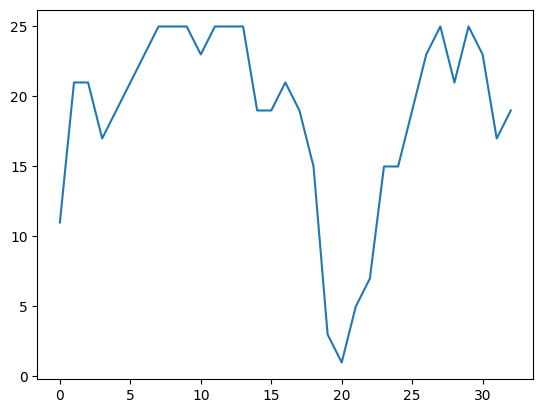

In [153]:
lat = initLattice(5, True)

mArr = calcMagArr(lat, 2.3, 1000)

plt.plot(np.arange(len(mArr)), mArr)

In [22]:
def autoCor2(lagTime: int, timeSeriesData: list) -> float:
    '''
    Calculate the autocorrelation of some time series data 
    '''
    avgData = np.average(timeSeriesData)
    varData = np.var(timeSeriesData)
    
    prodArr = []
    # now average the product of function * laggedFunction over the range until N-t
    N = len(timeSeriesData)
    for i in range(N - lagTime):
        product = (timeSeriesData[i] - avgData) * (timeSeriesData[i + lagTime] - avgData)
        prodArr.append(product)
    
    # average the product
    avgProd = np.average(prodArr)

    # calculate autoCor
    ac = avgProd / varData
    return ac

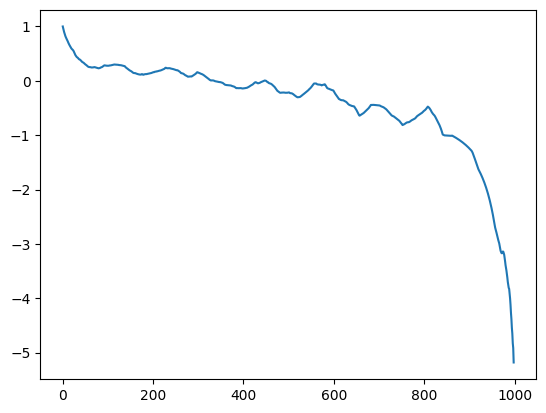

In [296]:
lat = initLattice(5, True)
mArr = calcMagArr(lat, 2, 1000)

signal = mArr

lagTimes = np.arange(0,len(signal))
#plt.plot(lagTimes, [-x for x in acf(noise_signal)])


ac =[autoCor2(t, signal) for t in lagTimes]
plt.plot(lagTimes, [autoCor2(t, signal) for t in lagTimes])

(-0.2, 1.1)

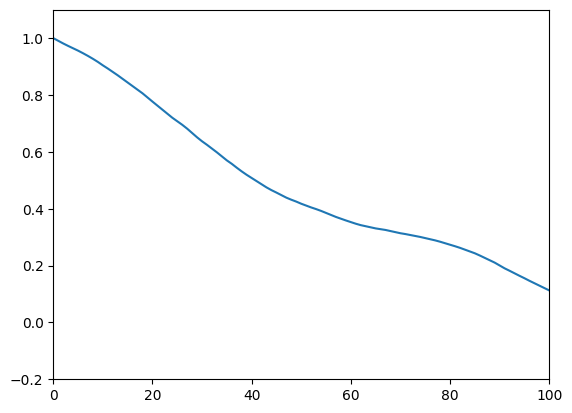

In [279]:
plt.plot(lagTimes, ac)
plt.xlim(0,100)
plt.ylim(-0.2,1.1)

In [235]:
def expFit(x,a,b,c):
    return a * np.exp(-b * x) + c

In [272]:
for i in range(len(ac)):
    if(ac[i]) < 0:
        print(i)
        break

261


first zero 336
[0.75880819 0.02724108 0.15537197]
36.709267695539125


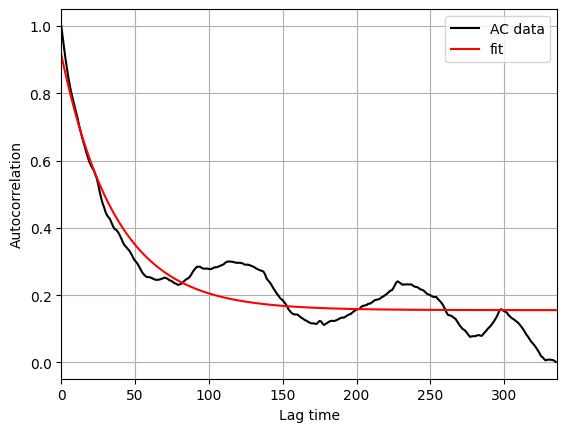

In [297]:
from scipy.optimize import curve_fit
from scipy.optimize import brentq


mTimeSeries = mArr

firstZero = 0
for i in range(len(ac)):
    if(ac[i]) < 0:
        firstZero = i
        break

arr = np.arange(firstZero)
tsAcArr = ac[0:firstZero]

dom = firstZero
print("first zero", firstZero)

fitParams = curve_fit(expFit, arr[0:dom], tsAcArr[0:dom])[0]
print(fitParams)
print(1/fitParams[1])

fitX = arr[0:dom]
param1 = fitParams[0]
param2 = fitParams[1]
param3 = fitParams[2]
fitY = [expFit(x, param1, param2, param3) for x in fitX] 

plt.plot(arr[0:dom], tsAcArr[0:dom], color="black", label="AC data")
plt.plot(fitX, fitY, color="red", label="fit")
plt.xlabel("Lag time")
plt.ylabel("Autocorrelation")
plt.legend()

plt.xlim(0,dom)
#plt.ylim(-0.2,1.1)

plt.grid()

5: 3.8697448272774886
10: 16.24773845047064
20: 67.96328784420429


temps for 5
100: 4.342500314286948
50: 5.6654988286313435
25: 6.01716457238519
10: 6.601875295794562
5: 13.228598288245271
3: 7.10344776409608
2.27: 23.481077267220243
1.5: 5.955266265018428
0.5: 8


what we learned: at high temps, the auto cor time seems somewhat useable?

this is actually probably a good indicator of phase transitition and useful to plot. Let's try for the ising model

In [330]:
tempRange = np.linspace(1,5,40)
acArr = []
for temp in tempRange:
    print("temp", temp)

    lat = initLattice(5, True)
    mArr = calcMagArr(lat, temp, 10000)

    signal = mArr

    lagTimes = np.arange(0,len(signal))
    #plt.plot(lagTimes, [-x for x in acf(noise_signal)])


    ac =[autoCor2(t, signal) for t in lagTimes]



    mTimeSeries = mArr

    firstZero = 0
    for i in range(len(ac)):
        if(ac[i]) < 0:
            firstZero = i
            break

    arr = np.arange(firstZero)
    tsAcArr = ac[0:firstZero]

    dom = firstZero
    print("first zero", firstZero)

    fitParams = curve_fit(expFit, arr[0:dom], tsAcArr[0:dom])[0]
    print("ac time: ", 1/fitParams[1])



    fitParams = curve_fit(expFit, arr[0:dom], tsAcArr[0:dom])[0]
    acArr.append(1/fitParams[1])


temp 1.0
first zero 755
ac time:  230.3580444551719
temp 1.1025641025641026


/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_8078/3195632883.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


first zero 236
ac time:  147.92586896948433
temp 1.205128205128205
first zero 120
ac time:  23.38480361435686
temp 1.3076923076923077
first zero 91
ac time:  40.73074737821835
temp 1.4102564102564101
first zero 182
ac time:  56.50119495169492
temp 1.5128205128205128
first zero 77
ac time:  110.66174292020446
temp 1.6153846153846154
first zero 241
ac time:  57.67997272154637
temp 1.717948717948718
first zero 117
ac time:  31.17386002017862
temp 1.8205128205128205
first zero 234
ac time:  53.4829124108412
temp 1.923076923076923
first zero 388
ac time:  760.2673074487093
temp 2.0256410256410255
first zero 367
ac time:  249.70793267672303
temp 2.128205128205128
first zero 375
ac time:  183.22686526751679
temp 2.230769230769231
first zero 229
ac time:  69.46074780518775
temp 2.333333333333333
first zero 137
ac time:  107.55443573870554
temp 2.435897435897436
first zero 2253
ac time:  66.84344782160464
temp 2.5384615384615383
first zero 361
ac time:  85.68910144975034
temp 2.641025641025641


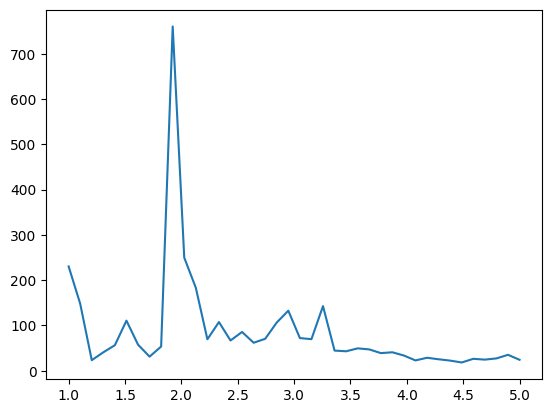

In [331]:
plt.plot(tempRange, acArr)

In [322]:
np.where(acArr == max(acArr))

(array([7]),)

In [323]:
tempRange[7]

2.473684210526316

### Wolff for the Ising model

do metropolis 5*N^2 times, then do a wolff flip???. 5(5^2)=5(25)=125 met steps until wolff flip

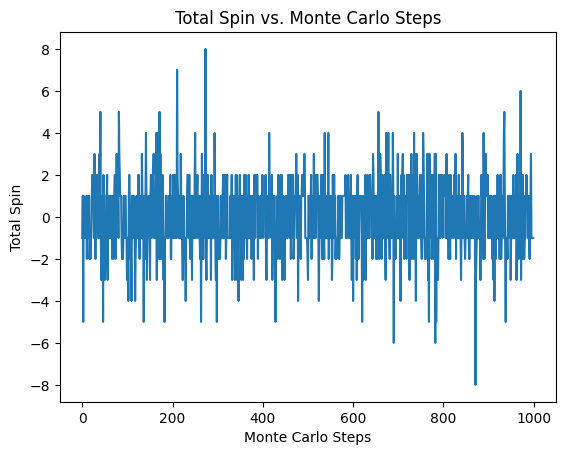

In [336]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_lattice(size):
    return np.random.choice([-1, 1], size=(size, size))

def cluster_flip(lattice, temperature, seed=(0, 0)):
    stack = [seed]
    visited = set([seed])
    spin_sum = lattice[seed[0], seed[1]]
    while stack:
        x, y = stack.pop()
        neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        for nx, ny in neighbors:
            if nx < 0 or nx >= lattice.shape[0] or ny < 0 or ny >= lattice.shape[1]:
                continue
            if (nx, ny) not in visited and np.random.rand() < 1 - np.exp(-2 * lattice[x, y] * lattice[nx, ny] / temperature):
                stack.append((nx, ny))
                visited.add((nx, ny))
                spin_sum += lattice[nx, ny]
    for x, y in visited:
        lattice[x, y] *= -1
    return spin_sum

def monte_carlo_step(lattice, temperature):
    size = lattice.shape[0]
    seed = (np.random.randint(size), np.random.randint(size))
    spin_sum = cluster_flip(lattice, temperature, seed)
    return lattice, spin_sum

def simulate(lattice_size, temperature, steps):
    lattice = initialize_lattice(lattice_size)
    spin_sums = []
    for _ in range(steps):
        lattice, spin_sum = monte_carlo_step(lattice, temperature)
        spin_sums.append(spin_sum)
    return lattice, spin_sums

# Parameters
lattice_size = 20
temperature = 10
steps = 1000

# Run simulation
lattice, spin_sums = simulate(lattice_size, temperature, steps)

# Plot spin sums
plt.plot(range(steps), spin_sums)
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Total Spin')
plt.title('Total Spin vs. Monte Carlo Steps')
plt.show()


In [337]:
def visit_neighbors(lattice, visited, row, col):
    """
    Recursively visit each neighbor of each site in a cluster of a lattice.

    Args:
    - lattice: The lattice representing the cluster.
    - visited: A boolean array representing visited sites.
    - row: The row index of the current site.
    - col: The column index of the current site.

    Returns:
    - None
    """

    # Mark the current site as visited
    visited[row][col] = True

    # Define possible directions (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Visit neighbors
    for dr, dc in directions:
        # Calculate neighbor's coordinates
        neighbor_row, neighbor_col = row + dr, col + dc

        # Check if neighbor is within lattice bounds and unvisited
        if (0 <= neighbor_row < len(lattice) and
                0 <= neighbor_col < len(lattice[0]) and
                lattice[neighbor_row][neighbor_col] == 1 and
                not visited[neighbor_row][neighbor_col]):
            # Recursively visit the neighbor
            visit_neighbors(lattice, visited, neighbor_row, neighbor_col)


In [360]:
size = 5
lat = initialize_lattice(size)
visit = np.zeros([size,size])
visit_neighbors(lat, visit, 2, 2)
visit

array([[1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1.]])

In [509]:
def visit_lattice(lattice, visited, row, col):
    """
    Recursively visit each neighbor of a site and continue until the whole lattice is visited.

    Args:
    - lattice: The lattice to visit.
    - visited: A boolean array representing visited sites.
    - row: The row index of the current site.
    - col: The column index of the current site.

    Returns:
    - None
    """

    # Mark the current site as visited
    visited[row][col] = True
    print("length of visited: ", len(visited))

    # Define possible directions (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Visit neighbors
    for dr, dc in directions:
        # Calculate neighbor's coordinates
        neighbor_row, neighbor_col = row + dr, col + dc

        print()
        print("pre: ", neighbor_row, neighbor_col)

        '''add periodic BC for neighbors coordinates'''
        # If site is in an edge, apply periodic boundary conditions
        maxCoordinate = len(lattice) - 1

        #row coordinate (vertical)
        if(neighbor_row < 0):
            neighbor_row = maxCoordinate
        if(neighbor_row > maxCoordinate):
            neighbor_row = 0

        #column coordinate (horizontal)
        if(neighbor_col < 0):
            neighbor_col = maxCoordinate
        if(neighbor_col > maxCoordinate):
            neighbor_col = 0

        '''end periodic BC'''
        print("post: ", neighbor_row, neighbor_col)

        # Check if neighbor is within lattice bounds and unvisited
        if (not visited[neighbor_row][neighbor_col]):
            # Recursively visit the neighbor
            print("input for next round: ", neighbor_row, neighbor_col)
            visit_lattice(lattice, visited, neighbor_row, neighbor_col)

lat = initialize_lattice(5)
print(lat)

# Initialize boolean array to track visited sites
visited = [[False] * len(lat[0]) for _ in range(len(lat))]

# Start visiting from a specific site (e.g., site at row 0, column 0)
start_row, start_col = np.random.randint(0,5), np.random.randint(0,5)
visit_lattice(lat, visited, start_row, start_col)

# Output the visited array to see the result
print("Visited array:")
for row in visited:
    print(row)


[[-1  1 -1  1  1]
 [-1  1 -1 -1 -1]
 [-1  1  1 -1  1]
 [ 1  1  1 -1  1]
 [-1 -1 -1  1 -1]]
length of visited:  5

pre:  -1 2
post:  4 2
input for next round:  4 2
length of visited:  5

pre:  3 2
post:  3 2
input for next round:  3 2
length of visited:  5

pre:  2 2
post:  2 2
input for next round:  2 2
length of visited:  5

pre:  1 2
post:  1 2
input for next round:  1 2
length of visited:  5

pre:  0 2
post:  0 2

pre:  2 2
post:  2 2

pre:  1 1
post:  1 1
input for next round:  1 1
length of visited:  5

pre:  0 1
post:  0 1
input for next round:  0 1
length of visited:  5

pre:  -1 1
post:  4 1
input for next round:  4 1
length of visited:  5

pre:  3 1
post:  3 1
input for next round:  3 1
length of visited:  5

pre:  2 1
post:  2 1
input for next round:  2 1
length of visited:  5

pre:  1 1
post:  1 1

pre:  3 1
post:  3 1

pre:  2 0
post:  2 0
input for next round:  2 0
length of visited:  5

pre:  1 0
post:  1 0
input for next round:  1 0
length of visited:  5

pre:  0 0
post:

above is debug, here i am slowly massaging the func into Wolff

In [542]:
def visit_lattice(lattice, visited, row, col):
    """
    Recursively visit each neighbor of a site and continue until the whole lattice is visited.

    Args:
    - lattice: The lattice to visit.
    - visited: A boolean array representing visited sites.
    - row: The row index of the current site.
    - col: The column index of the current site.

    Returns:
    - None
    """

    # Mark the current site as visited
    visited[row][col] = True
    #print("length of visited: ", len(visited))

    # Define possible directions (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Visit neighbors
    for dr, dc in directions:
        # Calculate neighbor's coordinates
        neighbor_row, neighbor_col = row + dr, col + dc

        #print()
        #print("pre: ", neighbor_row, neighbor_col)

        '''add periodic BC for neighbors coordinates'''
        # If site is in an edge, apply periodic boundary conditions
        maxCoordinate = len(lattice) - 1

        #row coordinate (vertical)
        if(neighbor_row < 0):
            neighbor_row = maxCoordinate
        if(neighbor_row > maxCoordinate):
            neighbor_row = 0

        #column coordinate (horizontal)
        if(neighbor_col < 0):
            neighbor_col = maxCoordinate
        if(neighbor_col > maxCoordinate):
            neighbor_col = 0

        '''end periodic BC'''
        #print("post: ", neighbor_row, neighbor_col)

        # Check if neighbor is within lattice bounds and neighbor site has same value
        if (lattice[neighbor_row][neighbor_col] == lattice[row][col] and 
            not visited[neighbor_row][neighbor_col]):
            # Recursively visit the neighbor
            #print("input for next round: ", neighbor_row, neighbor_col)
            visit_lattice(lattice, visited, neighbor_row, neighbor_col)

lat = initialize_lattice(5)
print(lat)

# Initialize boolean array to track visited sites
visited = [[False] * len(lat[0]) for _ in range(len(lat))]

# Start visiting from a specific site (e.g., site at row 0, column 0)
start_row, start_col = np.random.randint(0,5), np.random.randint(0,5)
print("starting coord: ", start_row, start_col)
print("starting val: ", lat[start_row][start_col])
visit_lattice(lat, visited, start_row, start_col)

# Output the visited array to see the result
print("Visited array:")
for row in visited:
    print(row)


[[ 1  1 -1  1  1]
 [-1 -1  1  1  1]
 [-1  1 -1 -1 -1]
 [ 1  1  1  1  1]
 [-1 -1 -1 -1 -1]]
starting coord:  1 0
starting val:  -1
Visited array:
[False, False, False, False, False]
[True, True, False, False, False]
[True, False, True, True, True]
[False, False, False, False, False]
[False, False, False, False, False]


In [543]:
for i in range(len(visited)):
    for j in range(len(visited)):
        if visited[i][j] == True:
            print(lat[i][j])

-1
-1
-1
-1
-1
-1


The code above seeks out a cluster formed of all sites of the same value neigboring a given initial site (applying periodic BC). Now i need to confirm prob works and then combine the two? At this point we should effectively have Wolff on Ising. Then, I change Padd and we have Wolff on Phi-4?

In [855]:
def visit_lattice(lattice, visited, row, col):
    """
    Recursively visit each neighbor of a site and continue until the whole lattice is visited.

    Args:
    - lattice: The lattice to visit.
    - visited: A boolean array representing visited sites.
    - row: The row index of the current site.
    - col: The column index of the current site.

    Returns:
    - None
    """

    # Mark the current site as visited
    visited[row][col] = True
    #print("length of visited: ", len(visited))

    # Define possible directions (up, down, left, right)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Visit neighbors
    for dr, dc in directions:
        # Calculate neighbor's coordinates
        neighbor_row, neighbor_col = row + dr, col + dc

        #print()
        #print("pre: ", neighbor_row, neighbor_col)

        '''add periodic BC for neighbors coordinates'''
        # If site is in an edge, apply periodic boundary conditions
        maxCoordinate = len(lattice) - 1

        #row coordinate (vertical)
        if(neighbor_row < 0):
            neighbor_row = maxCoordinate
        if(neighbor_row > maxCoordinate):
            neighbor_row = 0

        #column coordinate (horizontal)
        if(neighbor_col < 0):
            neighbor_col = maxCoordinate
        if(neighbor_col > maxCoordinate):
            neighbor_col = 0

        '''end periodic BC'''
        #print("post: ", neighbor_row, neighbor_col)

        # Check if neighbor is within lattice bounds and neighbor site has same value
        if (lattice[neighbor_row][neighbor_col] == lattice[row][col] and 
            not visited[neighbor_row][neighbor_col]):
            # Recursively visit the neighbor
            #print("input for next round: ", neighbor_row, neighbor_col)

            '''NEW: the prob you visit a site (given that it is new and has the same value) is given by e^-2BJ. Here we let j =1 '''
            T = 10 #2.88539
            randomVal = np.random.uniform(0,1)
            pAdd = 1 - np.exp(-2/T)
            #print()
            #print("randomVal: ", randomVal)
            #print("pAdd: ", pAdd)
            if(randomVal <= pAdd):
                print("visiting neighbor!")
                visit_lattice(lattice, visited, neighbor_row, neighbor_col)

lat = initialize_lattice(5)
print(lat)

# Initialize boolean array to track visited sites
visited = [[False] * len(lat[0]) for _ in range(len(lat))]

# Start visiting from a specific site (e.g., site at row 0, column 0)
start_row, start_col = np.random.randint(0,5), np.random.randint(0,5)
print("starting coord: ", start_row, start_col)
print("starting val: ", lat[start_row][start_col])
visit_lattice(lat, visited, start_row, start_col)

# Output the visited array to see the result
print("Visited array:")
for row in visited:
    print(row)


[[-1 -1  1  1  1]
 [ 1 -1  1 -1 -1]
 [ 1  1 -1  1  1]
 [-1 -1  1  1  1]
 [ 1 -1  1  1  1]]
starting coord:  2 1
starting val:  1
visiting neighbor!
visiting neighbor!
visiting neighbor!
Visited array:
[False, False, False, False, False]
[False, False, False, False, False]
[True, True, False, False, True]
[False, False, False, False, True]
[False, False, False, False, False]


In [879]:
def cluster_flip(lattice):
    visited_coords = []
    for i in range(len(visited)):
        for j in range(len(visited)):
            if(visited[i][j] == True):
                visited_coords.append((i,j))

    for i in visited_coords:
        lattice[i] *= -1

cluster_flip(lat)
print(lat)

[[-1 -1  1  1  1]
 [ 1 -1  1 -1 -1]
 [ 1  1 -1  1  1]
 [-1 -1  1  1  1]
 [ 1 -1  1  1  1]]
